# Problem Set 5
# Name: Nikhil Chakravarthy Chakkirala
# UBIT: nchakkir

# Question 1:
**Derive the restricted Boltzmann machine algorithm that you will implement, and explain your derivation. Implement the training and inference algorithms for RBM. Train RBMs with 20, 100 and 500 hidden nodes to generate MNIST images using the training data set. Generate MNIST images from the ones in the testing data set that have 20%, 50% and 80% pixels missing/removed. You are free to choose whether you want to use binary nodes or floating point nodes, but the derivation has to match the implementation.**

# Soln:


**Restricted Boltzmann Machine Algorithm:**
An RBM is a generative stochastic artificial neural network that can learn a probability distribution over its set of inputs. RBMs are a variant of Boltzmmann machines, with restriction that their neurons must form a bipartite graph, and there are no connections between nodes within a group. This restriction allows for more efficient training algorithms. RBMs can also be used in deep learning networks. 
RBMs have two layers: visible and hidden. The visible layer contains the input nodes and the hidden layer has nodes which have hidden or latent variables.

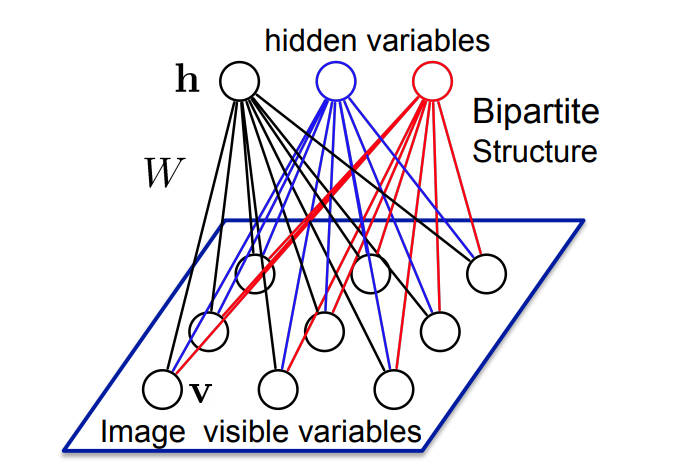
Energy is used as a metric for measuring the quality of a model in deep learning. High energy implies bad compatibility and energy-based models always try to minimize their predefined energy function.

For an RBM, the energy function is defined as:

$$ E(v,h) = - \sum_{i\epsilon visible} c_i v_i - \sum_{j\epsilon hidden} b_j h_j - \sum_{i,j} v_i h_j w_{ij}$$ 

where $v_i $ is the $i^{th}$ visibile unit,<br>
$h_j$ is the $j^{th}$ hidden unit<br>
$ c_i $ is the $ i^{th}$ bias attached to $i^{th}$ visibile unit<br>
$b_j$ is the $j^{th}$ bias attached to $j^{th}$ hidden unit <br>
$ w_{ij}$ is the $i^{th}$ visible unit and $j^{th}$ hidden unit <br><br>
In this sense, $ p(x,h) = \pi_{i}{\psi_i}$ is defined in terms of a Markov Random field, where each $\psi_i$ is called a potential function.<br>



The relation between the energy function and probability distribution is:
$$ p(v,h) = \frac{1}{Z}e^{-E(v,h)}$$<br>
we have, $Z=\frac{1}{\sum_{v,h}e^{-E(v,h)}}$ , the summation over all possible connections between visible and hidden nodes.<br>
So, $$ p(v,h) =\frac{e^{-E(v,h)}}{\sum_{v,h}e^{-E(v,h)}}$$<br><br>

The probability assigned to a visible unit is: $ p(v) = \frac{1}{Z}\sum_h e^{-E(v,h)}$<br><br>


Since there are no interactions between visible and hidden nodes, the input layer and hidden layer activations are mutually independent from hidden layer and input layer units respectively.

RBMs are basically Markov Random Fields with hidden variables. It's learning algorithms are based on gradient ascent on log-likelihood.<br>
For a model with parameter $\theta$, the log-likelihood given a single training example $u$ is <br>
$$ \ln p(u|\theta) = \ln \frac{1}{Z}\sum_h e^{-E(u,h)} = \ln \sum_h e^{-E(u,h)} - \ln \sum_{u,h} e^{-E(u,h)} $$
<br> <br>
The log-likelihood gradient is given as: <br>
$\partial \ln p(u|\theta)= \frac{\partial}{\partial\theta}(\ln \sum_h e^{-E(u,h)}) - \frac{\partial}{\partial\theta}(\ln \sum_{u,h} e^{-E(u,h)}) $
$$= -\frac{1}{\sum_h e^{-E(u,h)}}\ln \sum_h e^{-E(u,h)}\frac{\partial}{\partial\theta}E(u,h) + \frac{1}{\ln \sum_{u,h} e^{-E(u,h)}}\ln \sum_{u,h} e^{-E(u,h)}\frac{\partial}{\partial\theta}E(u,h) $$
$$= -\sum_h p(h|u)\frac{\partial}{\partial\theta}E(u,h) + \sum_{u,h} p(u,h)\frac{\partial}{\partial\theta}E(u,h) $$

In [45]:
# Import statements
import numpy
import matplotlib.pyplot as plt
import keras
import tensorflow
from keras.layers import Dense, Input, Conv2D, Lambda, Reshape, Conv2DTranspose, Flatten
from keras.datasets import mnist
from keras.models import Model
from keras.losses import binary_crossentropy, mse
from keras.utils import plot_model
from keras import backend
import os
from tensorflow.keras import layers
import PIL
from IPython import display

In [46]:
# Importing the dataset from keras. Common for all solutions
(trainData, trainLabels),(testData, testLabels)=tensorflow.keras.datasets.mnist.load_data()

In [47]:
# For solution 1
xTrain = trainData.reshape((len(trainData), numpy.prod(trainData.shape[1:])))/255.0
# trainData
trainData = trainData.astype('float32')/255
# For solution 2
trainSet = trainData.reshape((len(trainData), numpy.prod(trainData.shape[1:])))
# For solution 3
trainData = numpy.reshape(trainData, [-1, trainData.shape[1], trainData.shape[1], 1])
# For solution 1
xTest = testData.reshape((len(testData), numpy.prod(testData.shape[1:])))/255.0
#testData
testData = testData.astype('float32')/255
# For solution 2
testSet = testData.reshape((len(testData), numpy.prod(testData.shape[1:])))
# For solution 3
testData = numpy.reshape(testData, [-1, testData.shape[1], testData.shape[1], 1])

In [48]:
xTrain = numpy.where(xTrain >= 0.25, 1, 0)
xTest = numpy.where(xTest >= 0.25, 1, 0)
iter=2500
# Function for plotting the images
def plotImages(w,b,c,p):
    print("Pixels removed: ",p*100,"%")
    wCopy=w.copy()
    bCopy=b.copy()
    cCopy=c.copy()
    for i in range(0,16):
        x01=xTest[numpy.random.randint(0,10000)]
        ids=numpy.nonzero(x01)
        change_ids = numpy.random.choice(ids[0],int(p*len(ids[0])),replace=False)
        temp = numpy.copy(x01)
        temp[change_ids] = 0
        h01 = numpy.random.binomial(n=1, p=1/(1+numpy.exp(-(numpy.dot(temp,wCopy)+bCopy))))
        x02 = numpy.random.binomial(n=1, p=1/(1+numpy.exp(-(numpy.dot(h01, wCopy.T)+cCopy))))
        x02 = numpy.where(x02>0.5, 1, 0)
        x02=x02.reshape(28,28)
        plt.subplot(4,4,i+1)
        plt.imshow(x02,cmap='Greys_r')
        plt.axis('off')
    plt.show()
# Main function
def runMainFunctionFor(hiddenNodes):
    w=numpy.random.randn(xTrain.shape[1], hiddenNodes)/100
    b=numpy.random.randn(hiddenNodes)/100
    c=numpy.random.randn(xTrain.shape[1])
    initial=0
    for i in range(iter):
        trainBatch=xTrain[initial:initial+24]
        g=0
        g_b=0
        g_c=0
        for image in trainBatch:
            # Applying sigmoid function
            h=1/(1+numpy.exp(-(numpy.dot(image, w)+b)))
            imageCopy=numpy.copy(image)

            for k in range(0,10):
                t1=1/(1+numpy.exp(-(numpy.dot(imageCopy, w)+b)))
                hT=numpy.random.binomial(n=1,p=t1)
                t2=1/(1+numpy.exp(-(numpy.dot(hT, w.T)+c)))
                imageCopy=numpy.random.binomial(n=1,p=t2)
            hT=1/(1+numpy.exp(-(numpy.dot(imageCopy, w)+b)))
            g+=numpy.outer(image,h)-numpy.outer(imageCopy,hT)
            g_b+=h-hT
            g_c+=image-imageCopy
        w+=0.1*g/24
        b+=0.1*g_b/24
        c+=0.1*g_c/24
    print("Number of hidden nodes: ",hiddenNodes)
    plotImages(w,b,c,0.2)
    plotImages(w,b,c,0.5)
    plotImages(w,b,c,0.8)

Number of hidden nodes:  20
Pixels removed:  20.0 %


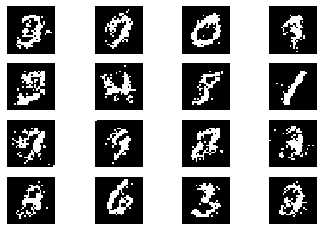

Pixels removed:  50.0 %


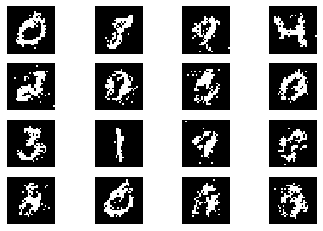

Pixels removed:  80.0 %


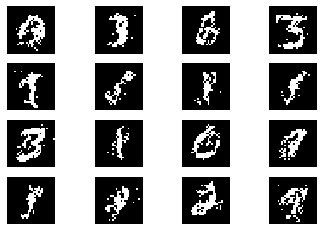

In [49]:
# 20 Hidden nodes
runMainFunctionFor(20)

Number of hidden nodes:  100
Pixels removed:  20.0 %


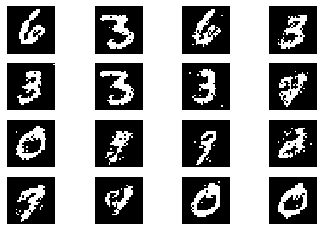

Pixels removed:  50.0 %


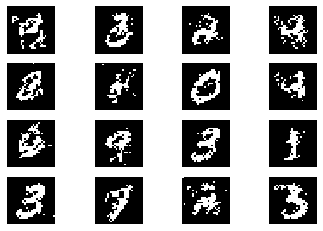

Pixels removed:  80.0 %


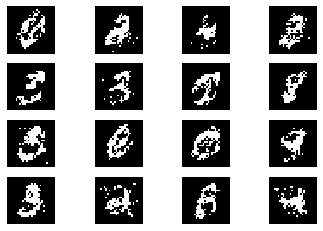

In [50]:
# 20 Hidden nodes
runMainFunctionFor(100)

Number of hidden nodes:  500
Pixels removed:  20.0 %


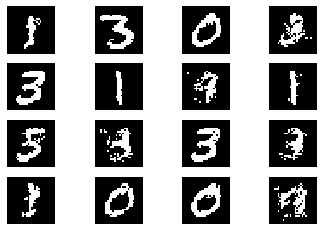

Pixels removed:  50.0 %


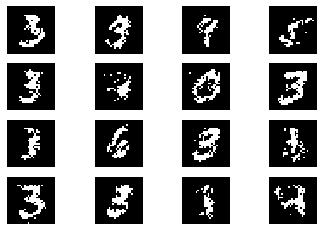

Pixels removed:  80.0 %


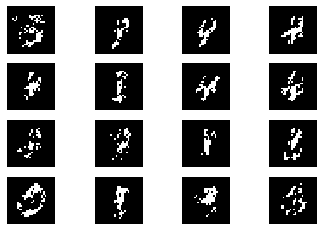

In [51]:
# 20 Hidden nodes
runMainFunctionFor(500)

# Question 2:
**Derive the variational autoencoder algorithm that you will implement, and explain your derivation. Implement the training and inference algorithms for VAE.  Train VAE with 2, 8 and 16 code units to encode MNIST images using the training data set. The neural network will be 784 input -> 256 hidden -> 2/8/16 code -> 256 hidden -> 784 output. Then  use the 2 code -> 256 hidden -> 784 output part of the trained network with 2 code units to generate images by varying each code unit from -3 to 3. You are free to choose the other parameters.**

# Soln:
**Variational Autoencoder:**
<br>VAEs are powerful generative models, having applications as diverse as from generating fake human faces, to producing purely synthetic music. While using generative models, more often, we would want to alte, or explore variations on data we already have, and not just in a random way, but in a desired specific direction. In such applications, VAEs work better than any other method.<br>

VAEs have one fundamentally unique property that separates them from autoencoders, and this is the property that makes them so useful for generative modelling --> Their latent spaces are continuous, allowing easy random sampling and interpolation.<br>

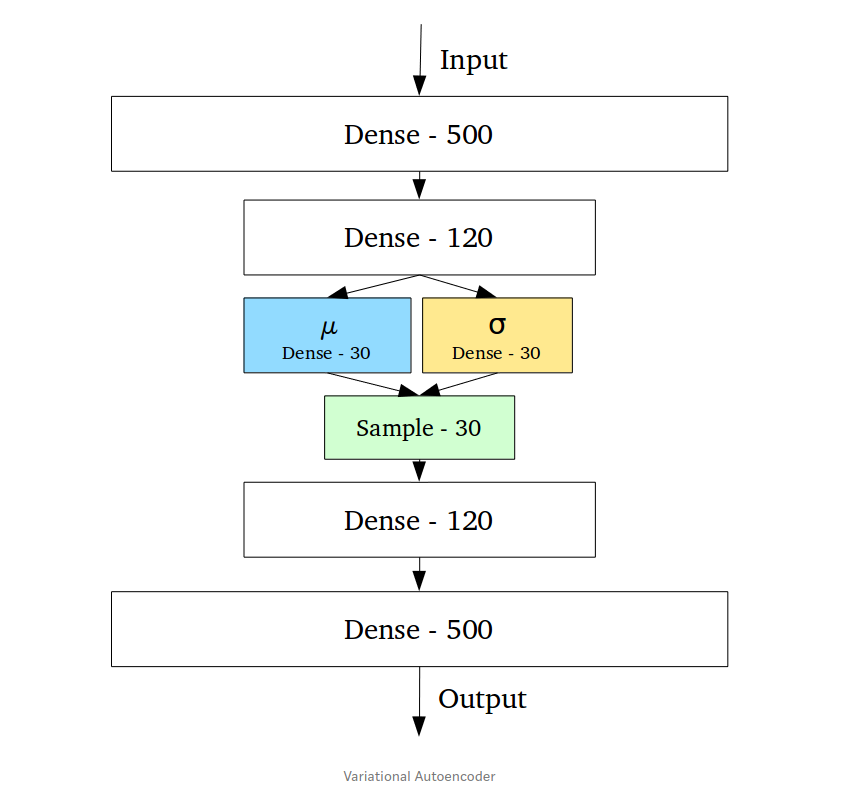


VAEs are Directed Probabilistic Graphical Models whose posterior is calculated by a neural network. The goal of a VAE is to find a distribution $q_{\phi}(Z|X)$ of some latent variables to generate new samples from $P_{\theta}(X|Z)$
where 
$Z$ is the hidden variable<br>
$X$ is the observed variable<br>
$q_{\phi}(Z|X)$ is the probabilistic encoder<br>
$P_{\theta}(X|Z)$ is the probabilistic decoder<br>

In summary, the goal is to find(estimate) the latent variables $Z$, given data $x$.

Variational inference is used to accomplish this goal. In other words, the approximation of $p(Z|X)$ is done by another distribution $q(Z|X)$ which is defined in such a way that it has a tractable solution since the general approximation of inference is not possible as it would require solving 'n' variables in the worst case.

Now, we have

KL-Divergence<br>

$D_{KL} [q_{\phi}(z|x(i)) || p_{\theta}(z|x(i))] = \sum_{z} q_{\phi}(z|x(i)) \log \frac{q_{\phi}(z|x(i))}{p_{\theta}(z|x(i))}$
$$= \mathbb{E} \left [\log \frac{q_{\phi}(z|x(i))}{p_{\theta}(z|x(i))}\right ] $$
$$= \mathbb{E} \left [\log q_{\phi}(z|x(i)) - \log p_{\theta}(z|x(i))\right ] $$<br>
Applyind Baye's theorem and expanding, we get<br>
$$= \mathbb{E} \left [\log q_{\phi}(z|x(i)) - \log p_{\theta}(x(i)|z) - \log p_{\theta}(z) + \log p_{\theta}(x(i))\right ]$$ <br>
Switching the $log p_{\theta}(x(i))$ to the left, we get<br>
$$D_{KL} [q_{\phi}(z|x(i)) || p_{\theta}(z|x(i))] - \log p_{\theta}(x(i)) = \mathbb{E} \left [\log q_{\phi}(z|x(i)) - \log p_{\theta}(x(i)|z) - \log p_{\theta}(z)\right ] $$<br>
Changing signs on both sides, we have<br>
==>$\log p_{\theta}(x(i)) - D_{KL} [q_{\phi}(z|x(i)) || p_{\theta}(z|x(i))] = \mathbb{E} \left [\log p_{\theta}(x(i)|z) + \log p_{\theta}(z) - \log q_{\phi}(z|x(i))  \right ]$<br>
$$= \mathbb{E} \left [\log p_{\theta}(x(i)|z)  \right ] - \mathbb{E} \left [\log q_{\phi}(z|x(i)) - \log p_{\theta}(z)    \right ]$$
$$= \mathbb{E} \left [\log p_{\theta}(x(i)|z)  \right ] -  D_{KL} [q_{\phi}(z|x(i)) || p_{\theta}(z)]$$

The above equation is the objective function of the Variational Autoencoder. The first term $\mathbb{E} \left [\log p_{\theta}(x(i)|z)  \right ]$ is the reconstruction likelihood and the second term $D_{KL} [q_{\phi}(z|x(i)) || p_{\theta}(z)]$ is the KL Divergence term which makes sure that the learned distribution is similar to the prior distribution


In [52]:
# Common for both solution 2 and 3
def sampler(args):
    zMean, zLogVar = args
    batch = backend.shape(zMean)[0]
    dimension = backend.int_shape(zMean)[1]
    epsilon = backend.random_normal(shape = (batch, dimension))
    return zMean + backend.exp(0.5 * zLogVar) * epsilon

In [53]:
originalDimension = trainSet.shape[1]
# 2 code units:
codeUnits = [2, 8, 16]

# 784 --> 256 --> 2/8/16 code units --> 256 --> 784
for codeUnit in codeUnits:
    # Inputs--> 784
    ip = Input(shape = (originalDimension, ))
    # Hidden nodes-->256
    x1 = Dense(256, activation = 'relu')(ip)
    print("Training with ",codeUnit," code units:")
    #Z-Mean with latent dimensions
    zMean1 = Dense(codeUnit)(x1)
    zLogVar1 = Dense(codeUnit)(x1)
    z1 = Lambda(sampler, output_shape = (codeUnit, ))([zMean1, zLogVar1])
    encoder1 = Model(ip, [zMean1, zLogVar1, z1])
    # encoder1.summary()
    # Latent inputs
    latentInputs1 = Input(shape = (codeUnit, ))
    # Reduced Dimensions
    x1 = Dense(256, activation='relu')(latentInputs1)
    #Back to original Dimension
    outputs1 = Dense(originalDimension, activation='sigmoid')(x1)
    decoder1 = Model(latentInputs1, outputs1)
#     decoder1.summary()
    # Instatiating the Variable AutoEncoder Model
    outputs1 = decoder1(encoder1(ip)[2])
    VAE1 = Model(ip, outputs1)
    reConLoss1 = (mse(ip, outputs1))*originalDimension
    klLoss1 = -0.5 * backend.sum(1 + zLogVar1 - backend.square(zMean1) - backend.exp(zLogVar1), axis = -1)
    vaeLoss1 = backend.mean(reConLoss1 + klLoss1)
    VAE1.add_loss(vaeLoss1)
    VAE1.compile(optimizer = 'adam')
#     VAE1.summary()
    VAE1.fit(trainSet, epochs = 50, batch_size = 128, validation_data = (testSet, None))



Training with  2  code units:


/home/nikhil/Downloads/Anaconda/envs/tensorflow_cpu/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_2 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_2.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 4s 62us/step - loss: 55.4321 - val_loss: 45.4196
Epoch 2/50
60000/60000 [==============================] - 3s 57us/step - loss: 44.2060 - val_loss: 43.2162
Epoch 3/50
60000/60000 [==============================] - 3s 58us/step - loss: 43.0035 - val_loss: 42.4023
Epoch 4/50
60000/60000 [==============================] - 3s 58us/step - loss: 42.2779 - val_loss: 41.7599
Epoch 5/50
60000/60000 [==============================] - 3s 58us/step - loss: 41.6576 - val_loss: 41.1666
Epoch 6/50
60000/60000 [==============================] - 3s 58us/step - loss: 41.1557 - val_loss: 40.8239
Epoch 7/50
60000/60000 [==============================] - 3s 58us/step - loss: 40.7337 - val_loss: 40.4472
Epoch 8/50
60000/60000 [==============================] - 3s 57us/step - loss: 40.4026 - val_loss: 40.1684
Epoch 9/50
60000/60000 [==============================] - 4s 59us/step - loss: 40.1139 - val_l

/home/nikhil/Downloads/Anaconda/envs/tensorflow_cpu/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_5 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_5.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 4s 61us/step - loss: 48.5543 - val_loss: 37.2556
Epoch 2/50
60000/60000 [==============================] - 3s 58us/step - loss: 35.9911 - val_loss: 34.5905
Epoch 3/50
60000/60000 [==============================] - 3s 58us/step - loss: 34.2497 - val_loss: 33.4277
Epoch 4/50
60000/60000 [==============================] - 3s 58us/step - loss: 33.3645 - val_loss: 32.7513
Epoch 5/50
60000/60000 [==============================] - 3s 58us/step - loss: 32.8144 - val_loss: 32.3384
Epoch 6/50
60000/60000 [==============================] - 3s 58us/step - loss: 32.4108 - val_loss: 31.9925
Epoch 7/50
60000/60000 [==============================] - 3s 58us/step - loss: 32.1151 - val_loss: 31.7183
Epoch 8/50
60000/60000 [==============================] - 3s 58us/step - loss: 31.8767 - val_loss: 31.5057
Epoch 9/50
60000/60000 [==============================] - 3s 58us/step - loss: 31.6521 - val_l

/home/nikhil/Downloads/Anaconda/envs/tensorflow_cpu/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_8 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_8.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 4s 61us/step - loss: 48.2670 - val_loss: 37.5094
Epoch 2/50
60000/60000 [==============================] - 4s 59us/step - loss: 35.8653 - val_loss: 34.2819
Epoch 3/50
60000/60000 [==============================] - 4s 59us/step - loss: 33.8441 - val_loss: 32.8653
Epoch 4/50
60000/60000 [==============================] - 4s 59us/step - loss: 32.8453 - val_loss: 32.1230
Epoch 5/50
60000/60000 [==============================] - 4s 59us/step - loss: 32.2250 - val_loss: 31.6965
Epoch 6/50
60000/60000 [==============================] - 4s 59us/step - loss: 31.8170 - val_loss: 31.4158
Epoch 7/50
60000/60000 [==============================] - 4s 59us/step - loss: 31.5432 - val_loss: 31.2482
Epoch 8/50
60000/60000 [==============================] - 4s 59us/step - loss: 31.3082 - val_loss: 30.9444
Epoch 9/50
60000/60000 [==============================] - 4s 59us/step - loss: 31.1163 - val_l

In [54]:
codeUnit = 2
# Inputs--> 784
ip = Input(shape = (originalDimension, ))
# Hidden nodes-->256
x1 = Dense(256, activation = 'relu')(ip)
#Z-Mean with latent dimensions
zMean1 = Dense(codeUnit)(x1)
zLogVar1 = Dense(codeUnit)(x1)
z1 = Lambda(sampler, output_shape = (codeUnit, ))([zMean1, zLogVar1])
encoder1 = Model(ip, [zMean1, zLogVar1, z1])
# encoder1.summary()
# Latent inputs
latentInputs1 = Input(shape = (codeUnit, ))
# Reduced Dimensions
x1 = Dense(256, activation='relu')(latentInputs1)
# Back to original Dimension
outputs1 = Dense(originalDimension, activation='sigmoid')(x1)
decoder1 = Model(latentInputs1, outputs1)
# decoder1.summary()
# Instatiating the Variable AutoEncoder Model
outputs1 = decoder1(encoder1(ip)[2])
VAE1 = Model(ip, outputs1)
reConLoss1 = (mse(ip, outputs1))*originalDimension
klLoss1 = -0.5 * backend.sum(1 + zLogVar1 - backend.square(zMean1) - backend.exp(zLogVar1), axis = -1)
vaeLoss1 = backend.mean(reConLoss1 + klLoss1)
VAE1.add_loss(vaeLoss1)
VAE1.compile(optimizer = 'adam')
# VAE1.summary()
VAE1.fit(trainSet, epochs = 50, batch_size = 128, validation_data = (testSet, None))




/home/nikhil/Downloads/Anaconda/envs/tensorflow_cpu/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_11 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_11.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 4s 60us/step - loss: 54.3053 - val_loss: 44.8294
Epoch 2/50
60000/60000 [==============================] - 3s 57us/step - loss: 43.9375 - val_loss: 42.9062
Epoch 3/50
60000/60000 [==============================] - 3s 58us/step - loss: 42.8027 - val_loss: 42.2473
Epoch 4/50
60000/60000 [==============================] - 3s 58us/step - loss: 42.2186 - val_loss: 41.6652
Epoch 5/50
60000/60000 [==============================] - 3s 57us/step - loss: 41.7584 - val_loss: 41.4053
Epoch 6/50
60000/60000 [==============================] - 3s 58us/step - loss: 41.3882 - val_loss: 41.0319
Epoch 7/50
60000/60000 [==============================] - 3s 58us/step - loss: 41.0684 - val_loss: 40.7653
Epoch 8/50
60000/60000 [==============================] - 3s 57us/step - loss: 40.8029 - val_loss: 40.5517
Epoch 9/50
60000/60000 [==============================] - 3s 58us/step - loss: 40.5689 - val_l

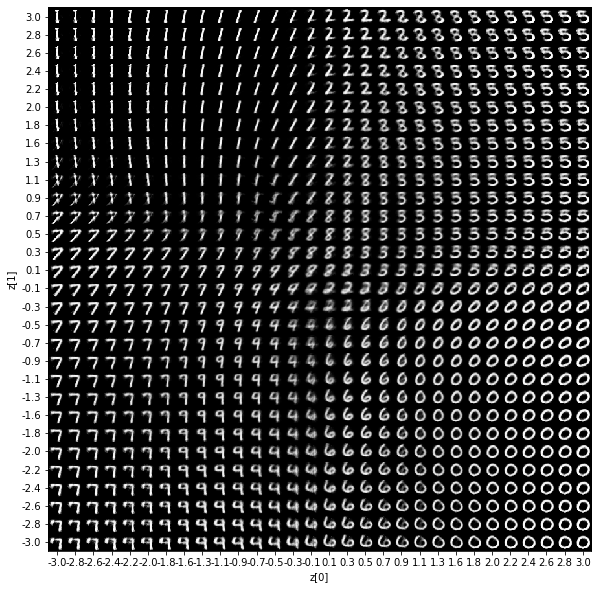

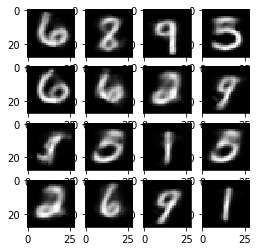

In [55]:
# Function for plotting results
figure = numpy.zeros((28*30, 28*30))
horizontalGrid = numpy.linspace(-3,3,30)
verticalGrid = numpy.linspace(-3,3,30)[::-1]
for i, y in enumerate(verticalGrid):
    for j, x in enumerate(horizontalGrid):
        zSample = numpy.array([[x,y]])
        decodedx = decoder1.predict(zSample)
        plottableDigit = decodedx[0].reshape(28,28)
        figure[i*28: (i+1)*28,j*28: (j+1)*28] = plottableDigit

plt.figure(figsize = (10,10))
startRange = 14
endRange = 29*28 + startRange + 1
rangeOfPixel = numpy.arange(startRange, endRange, 28)
sampleRangeHor = numpy.round(horizontalGrid, 1)
sampleRangeVer = numpy.round(verticalGrid, 1)
plt.xticks(rangeOfPixel, sampleRangeHor)
plt.yticks(rangeOfPixel, sampleRangeVer)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.imshow(figure, cmap='Greys_r')
plt.show()

plt.figure(figsize = (4, 4))
for i in range(0, 16):
    a = plt.subplot(4, 4, i+1)
    plt.imshow(decoder1.predict(numpy.random.normal(size = (1,2))).reshape(28, 28))
    plt.gray()
plt.show()

# Question 3:
**(Optional) Implement VAE to generate MNIST images, where you use convolutional neural network from encoder and deconvolutional neural network for decoder. This one should be super-easy (because there are many tutorials in the Internet and you have already solved problem 2) for you to catch up with the total score.**

# Soln:

In [57]:
# I'm using the sampler function and data imported in solution 2
# Encoder model:
inputs = x = Input(shape = (trainData.shape[1], trainData.shape[1], 1))
filters = 16
for i in range(0, 2):
    filters = filters * 2
    x = Conv2D(filters = filters, kernel_size = 3, strides = 2, padding = 'same', activation = 'relu')(x)
s = [x.shape[0],x.shape[1],x.shape[2],x.shape[3]]
# Generating Latent vector Q(z|X)
# !pip install pydot
import pydot
x = Flatten()(x)
x = Dense(16, activation = 'relu')(x)
zMean = Dense(2)(x)
zLogVar = Dense(2)(x)
z = Lambda(sampler, output_shape = (2, ))([zMean, zLogVar])
encoder = Model(inputs, [zMean, zLogVar, z])
# Decoder Model
latentInputs = Input(shape = (2, ))
x = Dense(s[1]*s[2]*s[3], activation = 'relu')(latentInputs)
x = Reshape((s[1],s[2],s[3]))(x)
filters = 64
for i in range(0, 2):
    x = Conv2DTranspose(filters = filters, kernel_size = 3, strides = 2, padding = 'same', activation = 'relu')(x)
    filters //= 2
outputs = Conv2DTranspose(filters = 1, kernel_size = 3, padding = 'same', activation = 'sigmoid')(x)
decoder = Model(latentInputs, outputs)
# decoder.summary()
outputs = decoder(encoder(inputs)[2])
# VAE Model
vae = Model(inputs, outputs)
reConLoss = (mse(backend.flatten(inputs), backend.flatten(outputs))) * trainData.shape[1] * trainData.shape[1]
klLoss = -0.5 * backend.sum(1 + zLogVar - backend.square(zMean) - backend.exp(zLogVar), axis = -1)
vaeLoss = backend.mean(reConLoss + klLoss)
vae.add_loss(vaeLoss)
vae.compile(optimizer = 'rmsprop')
# vae.summary()
vae.fit(trainData, epochs = 50, batch_size = 128, validation_data = (testData, None))

/home/nikhil/Downloads/Anaconda/envs/tensorflow_cpu/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_15 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_15.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 54s 896us/step - loss: 50.5138 - val_loss: 46.4526
Epoch 2/50
60000/60000 [==============================] - 52s 873us/step - loss: 43.5363 - val_loss: 42.8312
Epoch 3/50
60000/60000 [==============================] - 53s 876us/step - loss: 42.2359 - val_loss: 41.6314
Epoch 4/50
60000/60000 [==============================] - 52s 861us/step - loss: 41.3758 - val_loss: 40.9696
Epoch 5/50
60000/60000 [==============================] - 51s 845us/step - loss: 40.6579 - val_loss: 40.2918
Epoch 6/50
60000/60000 [==============================] - 51s 845us/step - loss: 40.0543 - val_loss: 40.2116
Epoch 7/50
60000/60000 [==============================] - 51s 846us/step - loss: 39.5688 - val_loss: 39.2025
Epoch 8/50
60000/60000 [==============================] - 49s 809us/step - loss: 39.1680 - val_loss: 38.8172
Epoch 9/50
60000/60000 [==============================] - 48s 795us/step - los

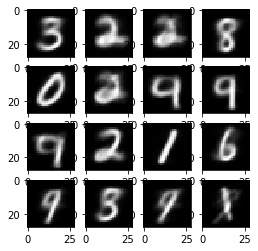

In [58]:
# Plotting the generated images
plt.figure(figsize = (4, 4))
for i in range(0, 16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(decoder.predict(numpy.random.normal(size = (1, 2))).reshape(28, 28))
    plt.gray()
plt.show()

# Question 4. 
**(Optional) Derive and explain the GAN algorithm. Implement GAN and train it from MNIST training data set to generate digits. Show images generated from GAN.**

# Soln:

**Generative Adversarial Networks**
The GAN comprises of two models: a generative model **G** and a discriminative model **D**. The generative model has to create data in such a way that it can fool the discriminator. The discriminative model has to be able to distinguish between actual and generated data.

**Important parameters:**
$G$ = Generator
$\theta_g$ = Parameters of generators
$D$ = Discriminator
$\theta_d$ = Parameters of discriminators
$P_{z}(z)$ = Input noise distribution
$P_{data}(x)$ = Original data distribution
$P_{g}(x)$ = Generated distribution

The loss function can be derived from the formula of binary cross-entropy loss, which is:

$$L(\hat{y},y) = [y.log\hat{y} + (1-y).log(1-\hat{y})]$$<br>
here, $y$ is the original data and $\hat{y}$ is the reconstructed data.
**Discriminator Loss:**
While training the discriminator, the label of the data coming from $P_{data}(x)$is $y=1$ (real data) and $\hat{y}=D(x)$. Substituting this in the above loss function, we get
$$L(D(x), 1) = log(D(x))---------------->Eqn1$$<br>
and for data coming from the generator, the label is $y=0$ (fake data) and $\hat{y} = D(G(z))$. So, in this case,
$$L(D(G(z)), 0) = log(1 - D(G(z)))------>Eqn2$$<br>
Now, the objective of discriminator is to correctly classify the fake and real dataset. For this, equations 1 and 2 should be maximized and final loss function for the discriminator can be given as:
$$L(D) = max[log(D(x)) + log(1 - D(G(z)))]-->Eqn3$$<br>

**Generator Loss:**
Now, the generator will be competing against the discriminator. So, it will try to minimize the equation 3. Hence, the loss function is
$$L(G) = min[log(D(x)) + log(1 - D(G(z)))]-->Eqn4$$

**Total Loss:**
Combining equations 3 and 4 we get total loss
$$L = min_{G}max_{D}[log(D(x)) + log(1 - D(G(z)))]-->Eqn5$$<br>

Now, the above loss function is valid only for a single data point. To consider the entire dataset, we need to take the expectation of equation 5:
$$min_{G}max_{D}V(D,G) = min_{G}max_{D}(E_{x\sim P_{data}(x)}[logD(x)] + E_{z\sim P_{z}(z)}[log(1 - D(G(z)))])---->Eqn6$$<br>
The above equation is the loss function of a GAN.

The algorithm is as follows:<br><br>
First, the real data and fake data are inserted into the discriminator with correct labels and training takes place. Gradients are propagated keeping generator fixed. The discriminator is updated by ascending its stochastic gradient because for discriminator, we want to maximize the loss function given in equation 6.<br><br>
Second, the generator is updated by keeping the discriminator fixed and passing fake data with fake labels in order to fool the discriminator. In other words, the generator is updated by descending its stochastic gradient because for generator, we want to minimize the loss function given in equation 6.

# Note: I've tried implementing the GAN algorithm, but could not finish it. I didn't understand where the mistake was since I was not getting any error and I was also not getting the correct images. But since its already late, I've left it as is.

In [ ]:
# Importing the dataset from keras
(data_train, label_train),(data_test, label_test)=tensorflow.keras.datasets.mnist.load_data()

In [ ]:
data_train = data_train.reshape(data_train.shape[0], 28, 28, 1).astype('float32')
data_train = (data_train - 127.5) / 127.5

In [ ]:
trainDataset = tensorflow.data.Dataset.from_tensor_slices(data_train).shuffle(60000).batch(256)

In [ ]:
# Generator model

generatorModel = tensorflow.keras.Sequential()
generatorModel.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
generatorModel.add(layers.BatchNormalization())
generatorModel.add(layers.LeakyReLU())
generatorModel.add(layers.Reshape((7,7,256)))
generatorModel.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
generatorModel.add(layers.BatchNormalization())
generatorModel.add(layers.LeakyReLU())
generatorModel.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
generatorModel.add(layers.BatchNormalization())
generatorModel.add(layers.LeakyReLU())
generatorModel.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

# Noise
n = tensorflow.random.normal([1, 100])
imageProduced = generatorModel(n, training = False)

In [ ]:
# Discriminator (CNN based Classifier)

discriminatorModel = tensorflow.keras.Sequential()
discriminatorModel.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
discriminatorModel.add(layers.LeakyReLU())
discriminatorModel.add(layers.Dropout(0.3))
discriminatorModel.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
discriminatorModel.add(layers.LeakyReLU())
discriminatorModel.add(layers.Dropout(0.3))
discriminatorModel.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
discriminatorModel.add(layers.LeakyReLU())
discriminatorModel.add(layers.Dropout(0.3))
discriminatorModel.add(layers.Flatten())
discriminatorModel.add(layers.Dense(1))
result = discriminatorModel(imageProduced)

In [195]:
# Computing Cross Entropy Loss

crossEntropy = tensorflow.keras.losses.BinaryCrossentropy(from_logits=True)

generatorOptimizer = tensorflow.keras.optimizers.Adam(1e-4)
discriminatorOptimizer = tensorflow.keras.optimizers.Adam(1e-4)


In [196]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tensorflow.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generatorModel,
                                 discriminator=discriminatorModel)

# Number of Epochs: 50, Noise Dimension: 100, Number of examples to generate: 16
seed = tensorflow.random.normal([16, 100])

In [203]:
# Helper function to train image batches
def trainer(imagesBatch):
    genLoss = []
    disLoss = []
    noise = tensorflow.random.normal([256, 100])
    with tensorflow.GradientTape() as generatorTape, tensorflow.GradientTape() as discriminatorTape:
        imagesProduced = generatorModel(noise, training = True)
        realOutput = discriminatorModel(imagesBatch, training = True)
        fakeOutput = discriminatorModel(imagesProduced, training = True)
        generatorLoss = crossEntropy(tensorflow.ones_like(fakeOutput), fakeOutput)
        discriminatorLoss = crossEntropy(tensorflow.ones_like(realOutput), realOutput) + crossEntropy(tensorflow.ones_like(fakeOutput), fakeOutput)
        genLoss.append(generatorLoss)
        disLoss.append(discriminatorLoss)
    generatorGradients = generatorTape.gradient(generatorLoss, generatorModel.trainable_variables)
    generatorOptimizer.apply_gradients(zip(generatorGradients, generatorModel.trainable_variables))
    discriminatorGradients = discriminatorTape.gradient(discriminatorLoss, discriminatorModel.trainable_variables)
    discriminatorOptimizer.apply_gradients(zip(discriminatorGradients, discriminatorModel.trainable_variables))
    return genLoss, disLoss

In [204]:
# Helper function to generate and save images
def helper(model, test):
    predictionSet = model(test, training = False)
    fig = plt.figure(figsize = (4, 4))
    for index in range(predictionSet.shape[0]):
        plt.subplot(4, 4, index + 1)
        plt.imshow(predictionSet[index, :, :, 0]* 127.5 + 127.5, cmap = 'gray')
    plt.show()

In [205]:
# Main function for training the dataset
# !pip install time
import time
def trainData(data):
    genLoss = []
    disLoss = []
    for epoch in range(0, 50):
        startTime = time.time()
        for image in data:
            g, d = trainer(image)
            genLoss.append(g)
            disLoss.append(d)
        display.clear_output(wait=True)
        helper(generatorModel, seed)
        if (epoch + 1) % 15 == 0:
              checkpoint.save(file_prefix = checkpoint_prefix)
    display.clear_output(wait=True)
    helper(generatorModel, seed)
    return genLoss, disLoss

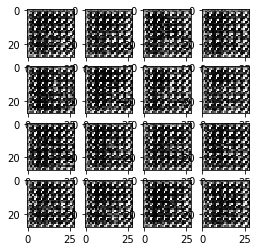

KeyboardInterrupt: 

In [206]:
 generatorLoss, discriminatorLoss = trainData(trainDataset)

In [201]:
checkpoint.restore(tensorflow.train.latest_checkpoint(checkpoint_dir))

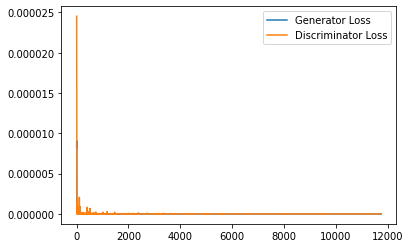

In [202]:
plt.figure()
plt.plot(generatorLoss, label = 'Generator Loss')
plt.plot(discriminatorLoss, label = 'Discriminator Loss')
plt.legend();


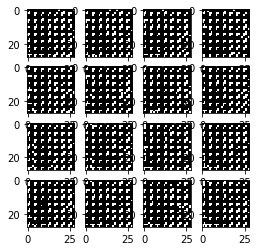

KeyboardInterrupt: 

In [64]:
# For 250 Epochs
def trainData2(data, epoch):
    genLoss = []
    disLoss = []
    for epoch in range(0, epoch):
        startTime = time.time()
        for image in data:
            g, d = trainer(image)
            genLoss.append(g)
            disLoss.append(d)
        display.clear_output(wait=True)
        helper(generatorModel, seed)
        if (epoch + 1) % 15 == 0:
              checkpoint.save(file_prefix = checkpoint_prefix)
    display.clear_output(wait=True)
    helper(generatorModel, seed)
    return genLoss, disLoss
generatorLoss2, discriminatorLoss2 = trainData2(trainDataset, 250)


In [ ]:
plt.figure()
plt.plot(generatorLoss2[::100], label='Generator Network Lo  ss')
plt.plot(discriminatorLoss2[::100], label='Discriminator Network Loss')
plt.legend()

# References:
1. Pattern Classification book
2. Slides by Prof. Wen Dong
3. Neural Networks quiz by Prof. Wen Dong on UBLearns
4. https://towardsdatascience.com/the-math-behind-gans-generative-adversarial-networks-3828f3469d9c
5. https://www.tensorflow.org/tutorials/generative/cvae
6. https://www.tensorflow.org/tutorials/generative/dcgan
7. https://www.codecogs.com/latex/eqneditor.php
8. https://en.wikipedia.org/wiki/Restricted_Boltzmann_machine
9. https://en.wikipedia.org/wiki/Gradient_descent
10. http://blog.echen.me/2011/07/18/introduction-to-restricted-boltzmann-machines/
11. https://web.archive.org/web/20160920122139/http://deeplearning4j.org/understandingRBMs.html
12. https://en.wikipedia.org/wiki/Autoencoder
13. https://www.tensorflow.org/tutorials
14. http://deeplearning.net/tutorial/rbm.html
15. https://www.youtube.com/watch?v=wdKYveLIxgU&list=PLdxQ7SoCLQANizknbIiHzL_hYjEaI-wUe&index=2
16. https://www.edureka.co/ai-deep-learning-with-tensorflow